# Airbnb

## Context and objectives

Your have been missioned by the CEO of Airbnb Spain to analyze accommodations park in Madrid. More specifically, you are going to investigate the price of Airbnb accommodations in Madrid from April 2021 to April 2022.

# Import

In [136]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

## The database

### Download

Download the database in the `db` directory:

In [2]:
!curl https://wagon-public-datasets.s3.amazonaws.com/certification/airbnb_profits_analysis/airbnb.sqlite > db/airbnb.sqlite

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  306M  100  306M    0     0  29.8M      0  0:00:10  0:00:10 --:--:-- 31.3M


Check the database has been saved:

In [3]:
!tree

.
├── airbnb.ipynb
├── airbnb.slides.html
├── db
│   ├── airbnb.sqlite
│   └── airbnb.xml
├── neighbourhood.png
├── README.md
└── tests
    ├── analysis.pickle
    └── query.pickle

2 directories, 8 files


### Schema

Open the database with your favorite tool (DBeaver, sqlite3, Postico,...) then:
- **📝 Draw the database schema in Le Wagon editor on https://kitt.lewagon.com/db**
- **💾 Save the `XML` version of the database schema in a `db/airbnb.xml` file**

Once done, check you have the `airbnb.xml` file in the `db` directory:

In [4]:
!tree

.
├── airbnb.ipynb
├── airbnb.slides.html
├── db
│   ├── airbnb.sqlite
│   └── airbnb.xml
├── neighbourhood.png
├── README.md
└── tests
    ├── analysis.pickle
    └── query.pickle

2 directories, 8 files


### Querying the database

In order to perform some analysis, you need to fetch the following information from **all** the accommodations of the database:
- `id`: the unique identifier of the accommodation
- `price`: the value paid per night in USD
- `neighbourhood`: the neighbourhood the accommodation belongs to
- `neighbourhood_group`: the neighbourhoods group the accommodation belongs to
- `bedrooms`: the number of bedrooms 
- `beds`: the number of beds
- `accommodates`: number of persons the accommodation is suited for
- `amenities`: a list of amenities of the accommodation
- `minimum_nights`: the minimum number of nights which can be booked
- `maximum_nights`: the maximum number of nights which can be booked in a row
- `host_id`: the unique identifier of the host
- `host_since`: date of the first listing of the host
- `host_neighbourhood`: the neighbourhood the accommodation belongs to
- `host_location`: the location of the host
- `host_response_time`: the category of response time of the host
- `host_response_rate`: the response rate of the host in %
- `host_acceptance_rate`: the acceptance rate of the host in %
- `host_is_superhost`: whether or not the host is a Superhost
- `host_has_profile_pic`: whether or not the host has a profile picture
- `host_identity_verified`: whether or not the identity of the host is verified
- `latitude`: latitude of the accommodation
- `longitude`: longitude of the accommodation
- `room_type`: category of the accommodation
- `property_type`: category of the property the accommodation belongs to
- `review_scores_rating`: average score rating for the accommodation in %
- `number_of_reviews`: total number of reviews
- `yearly_availability`: the total number of days where the accommodation available for guests in a year

**📝 Write an SQL query to fetch the above information and store it as a `str` in the `query` variable.**

In [5]:
# YOUR CODE HERE
query = """SELECT   a.id,
                    a.price,
                    n.name,
                    ng.name,
                    a.bedrooms,
                    a.accommodates,
                    a.amenities,
                    a.minimum_nights,
                    a.maximum_nights,
                    a.host_id,
                    a.host_since,
                    a.host_neighbourhood,
                    a.host_location,
                    a.host_response_time,
                    a.host_response_rate,
                    a.host_acceptance_rate,
                    a.host_is_superhost,
                    a.host_has_profile_pic,
                    a.host_identity_verified,
                    a.latitude,
                    a.longitude,
                    a.room_type,
                    a.property_type,
                    a.review_scores_rating,
                    COUNT(r.id) as number_of_reviews,
                    COUNT(av.date)/COUNT(DISTINCT(STRFTIME('%Y', DATE(av.date)))) as yearly_availability
            FROM accommodations a
            LEFT JOIN neighbourhoods n on a.neighbourhood_id = n.id
            LEFT JOIN neighbourhood_groups ng on n.neighbourhood_group_id = ng.id
            LEFT JOIN availabilities av on a.id = av.id
            LEFT JOIN reviews r on av.accommodation_id = r.accommodation_id
            GROUP BY a.id
            """

**📝 Connect to the `airbnb.sqlite` database and use the query above to store the data in a `DataFrame` named `data`. Display the 10 first rows**

In [6]:
# YOUR CODE HERE
# Connecting to sqlite
conn = sqlite3.connect('db/airbnb.sqlite')
# Create data
data = pd.read_sql(query, conn)

data.head(10)

,id,price,name,name,bedrooms,accommodates,amenities,minimum_nights,maximum_nights,host_id,...,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,property_type,review_scores_rating,number_of_reviews,yearly_availability
0,6369,$60.00,Hispanoamérica,Chamartín,1.0,2,"[""Kitchen"", ""Elevator"", ""Extra pillows and bla...",1,1125,13660,...,t,t,t,40.45724,-3.67688,Private room,Private room in apartment,98.0,8,8.0
1,21853,$31.00,Cármenes,Latina,1.0,1,"[""Bed linens"", ""Refrigerator"", ""Dishes and sil...",4,40,83531,...,f,t,t,40.40381,-3.74130,Private room,Private room in apartment,92.0,53,53.0
2,23001,$50.00,Legazpi,Arganzuela,3.0,6,"[""Pool"", ""Dishwasher"", ""Bed linens"", ""Refriger...",15,730,82175,...,f,t,t,40.38840,-3.69511,Entire home/apt,Entire apartment,NaN,77,77.0
3,24805,$92.00,Universidad,Centro,NaN,3,"[""Refrigerator"", ""Host greets you"", ""Dishes an...",5,730,346366726,...,f,t,f,40.42183,-3.70529,Entire home/apt,Entire apartment,98.0,272,272.0
4,26825,$26.00,Legazpi,Arganzuela,1.0,1,"[""Elevator"", ""Patio or balcony"", ""Bed linens"",...",2,1125,114340,...,f,t,t,40.38975,-3.69018,Private room,Private room in house,94.0,23,23.0
5,28200,$85.00,Legazpi,Arganzuela,3.0,6,"[""TV with standard cable"", ""Kitchen"", ""Elevato...",1,365,82175,...,f,t,t,40.38860,-3.69492,Entire home/apt,Entire apartment,80.0,1,1.0
6,30320,$65.00,Sol,Centro,1.0,2,"[""TV with standard cable"", ""Heating"", ""Air con...",5,180,130907,...,f,t,f,40.41476,-3.70418,Entire home/apt,Entire apartment,93.0,78,78.0
7,30959,$54.00,Embajadores,Centro,1.0,2,"[""TV with standard cable"", ""Kitchen"", ""Elevato...",3,730,132883,...,f,t,f,40.41259,-3.70105,Entire home/apt,Entire loft,88.0,197,197.0
8,37859,"$1,400.00",Palacio,Centro,2.0,5,"[""Kitchen"", ""Elevator"", ""Dryer"", ""Iron"", ""Wifi...",3,730,162701,...,t,t,t,40.41844,-3.71073,Entire home/apt,Entire apartment,NaN,31,31.0
9,40718,$79.00,Justicia,Centro,1.0,4,"[""Bed linens"", ""Refrigerator"", ""Crib"", ""Dishes...",3,500,34217435,...,t,t,t,40.41969,-3.69736,Entire home/apt,Entire apartment,93.0,0,1.0


In [7]:
data.shape

(19618, 26)

In [8]:
data.max(axis=0)

/tmp/ipykernel_7648/3933222813.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.max(axis=0)


id                         49187791
price                       $999.00
name                          Zofío
name                     Villaverde
bedrooms                       15.0
accommodates                     16
amenities                        []
minimum_nights                 1125
maximum_nights               142365
host_id                   396428081
latitude                   40.56274
longitude                   -3.5319
room_type               Shared room
property_type                  Yurt
review_scores_rating          100.0
number_of_reviews               549
yearly_availability           549.0
dtype: object

### 💾 Save your results

Run the cell below to save your results.

In [9]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'query',
    query=query,
    shape=data.shape,
    columns=data.columns,
    host_locations=data['host_location'].unique(),
    maximums=data.max(axis=0),
    minimums=data.min(axis=0),
    means=data.mean(axis=0)
)
result.write()

/tmp/ipykernel_7648/3634933146.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  maximums=data.max(axis=0),
/tmp/ipykernel_7648/3634933146.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  minimums=data.min(axis=0),
/tmp/ipykernel_7648/3634933146.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means=data.mean(axis=0)


### Load data from a CSV file

We provide you a clean dataset you should start withto perform your analysis:

**📝 Load the data from this URL: https://wagon-public-datasets.s3.amazonaws.com/certification/airbnb_profits_analysis/airbnb.csv inside a `DataFrame` named `accommodations`. Display the 10 first rows.** 

In [10]:
# YOUR CODE HERE
url = "https://wagon-public-datasets.s3.amazonaws.com/certification/airbnb_profits_analysis/airbnb.csv"

accommodations = pd.read_csv(url)
accommodations.head(10)

,id,price,neighbourhood,neighbourhood_group,bedrooms,beds,accommodates,amenities,minimum_nights,maximum_nights,...,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,property_type,review_scores_rating,number_of_reviews,yearly_availability
0,6369,$60.00,Hispanoamérica,Chamartín,1.0,1.0,2,"[""Kitchen"", ""Elevator"", ""Extra pillows and bla...",1,1125,...,t,t,t,40.45724,-3.67688,Private room,Private room in apartment,98.0,78,180.0
1,21853,$31.00,Cármenes,Latina,1.0,1.0,1,"[""Bed linens"", ""Refrigerator"", ""Dishes and sil...",4,40,...,f,t,t,40.40381,-3.74130,Private room,Private room in apartment,92.0,33,364.0
2,23001,$50.00,Legazpi,Arganzuela,3.0,5.0,6,"[""Pool"", ""Dishwasher"", ""Bed linens"", ""Refriger...",15,730,...,f,t,t,40.38840,-3.69511,Entire home/apt,Entire apartment,NaN,0,366.0
3,26825,$26.00,Legazpi,Arganzuela,1.0,1.0,1,"[""Elevator"", ""Patio or balcony"", ""Bed linens"",...",2,1125,...,f,t,t,40.38975,-3.69018,Private room,Private room in house,94.0,149,365.0
4,28200,$85.00,Legazpi,Arganzuela,3.0,4.0,6,"[""TV with standard cable"", ""Kitchen"", ""Elevato...",1,365,...,f,t,t,40.38860,-3.69492,Entire home/apt,Entire apartment,80.0,3,365.0
5,30320,$65.00,Sol,Centro,1.0,2.0,2,"[""TV with standard cable"", ""Heating"", ""Air con...",5,180,...,f,t,f,40.41476,-3.70418,Entire home/apt,Entire apartment,93.0,170,351.0
6,30959,$54.00,Embajadores,Centro,1.0,1.0,2,"[""TV with standard cable"", ""Kitchen"", ""Elevato...",3,730,...,f,t,f,40.41259,-3.70105,Entire home/apt,Entire loft,88.0,8,NaN
7,37859,"$1,400.00",Palacio,Centro,2.0,3.0,5,"[""Kitchen"", ""Elevator"", ""Dryer"", ""Iron"", ""Wifi...",3,730,...,t,t,t,40.41844,-3.71073,Entire home/apt,Entire apartment,NaN,0,365.0
8,40718,$79.00,Justicia,Centro,1.0,2.0,4,"[""Bed linens"", ""Refrigerator"", ""Crib"", ""Dishes...",3,500,...,t,t,t,40.41969,-3.69736,Entire home/apt,Entire apartment,93.0,118,302.0
9,40916,$90.00,Universidad,Centro,1.0,3.0,3,"[""Kitchen"", ""Elevator"", ""Wifi"", ""Heating"", ""Lo...",5,180,...,f,t,f,40.42247,-3.70577,Entire home/apt,Entire apartment,93.0,48,346.0


In [11]:
accommodations.shape

(17747, 27)

## Exploratory analysis

In this section, explore the dataset and visualize the data to get some intuitions.

In particular, try to make a sense of the relationships between the price of an accommodation and its characteristics.


ℹ️ We are **not** waiting for multivariate analysis at this point (using the `statsmodels` package)

In [12]:
# YOUR CODE HERE
accommodations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17747 entries, 0 to 17746
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      17747 non-null  int64  
 1   price                   17747 non-null  object 
 2   neighbourhood           17747 non-null  object 
 3   neighbourhood_group     17747 non-null  object 
 4   bedrooms                17747 non-null  float64
 5   beds                    17747 non-null  float64
 6   accommodates            17747 non-null  int64  
 7   amenities               17747 non-null  object 
 8   minimum_nights          17747 non-null  int64  
 9   maximum_nights          17747 non-null  int64  
 10  host_id                 17747 non-null  int64  
 11  host_since              17268 non-null  object 
 12  host_neighbourhood      11605 non-null  object 
 13  host_location           17229 non-null  object 
 14  host_response_time      10042 non-null

### Price column is an object, we have to convert it to float

In [13]:
accommodations['price'][1:]

1        $31.00
2        $50.00
3        $26.00
4        $85.00
5        $65.00
          ...  
17742    $40.00
17743    $23.00
17744    $21.00
17745    $22.00
17746    $19.00
Name: price, Length: 17746, dtype: object

In [14]:
accommodations['price'] = accommodations['price'].str.replace("$","").str.replace(",","").astype(float)

/tmp/ipykernel_7648/2561587687.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  accommodations['price'] = accommodations['price'].str.replace("$","").str.replace(",","").astype(float)


In [15]:
accommodations['price'].min()

8.0

In [16]:
accommodations['price'].max()

9999.0

### Ok, now we can visualize the price

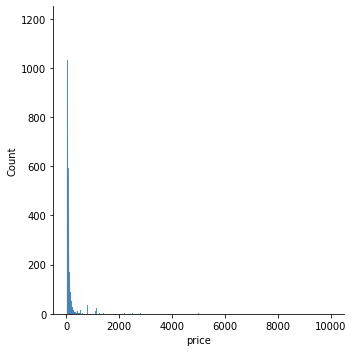

In [17]:
sns.displot(accommodations["price"])

### Most of prices are lower than 500$

<AxesSubplot:xlabel='review_scores_rating', ylabel='price'>

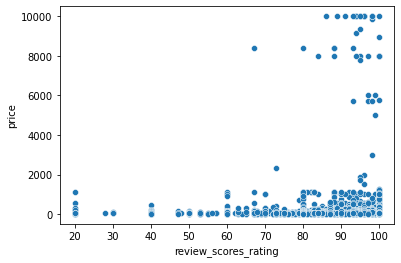

In [18]:
sns.scatterplot(x='review_scores_rating', y='price', data=accommodations)

### Higher prices seems quite good regarding the reviews

<AxesSubplot:>

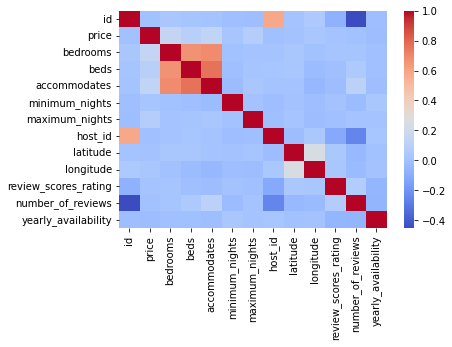

In [19]:
corr = accommodations.corr()
sns.heatmap(corr, cmap="coolwarm")

### None of the columns have an important impact on the price

In [20]:
data.corrwith(accommodations["price"]).sort_values(ascending=False)

longitude               0.014836
review_scores_rating    0.009624
minimum_nights          0.008553
id                      0.001325
latitude               -0.001955
accommodates           -0.002163
maximum_nights         -0.003239
bedrooms               -0.005304
yearly_availability    -0.005764
number_of_reviews      -0.010434
host_id                -0.010648
dtype: float64

### Maybe the location when we look at the longitude

<AxesSubplot:xlabel='neighbourhood', ylabel='price'>

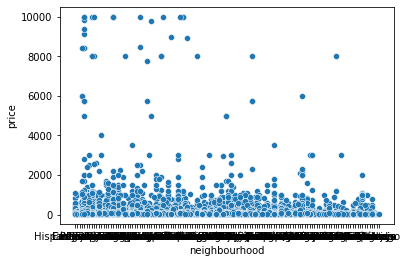

In [21]:
sns.scatterplot(x='neighbourhood', y='price', data=accommodations)

<AxesSubplot:xlabel='neighbourhood', ylabel='review_scores_rating'>

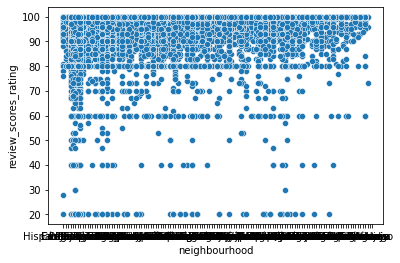

In [22]:
sns.scatterplot(x='neighbourhood', y='review_scores_rating', data=accommodations)

In [23]:
accommodations["neighbourhood"].unique()

array(['Hispanoamérica', 'Cármenes', 'Legazpi', 'Sol', 'Embajadores',
       'Palacio', 'Justicia', 'Universidad', 'Goya', 'Peñagrande',
       'Recoletos', 'Palomeras Bajas', 'Valverde', 'Pueblo Nuevo',
       'Almagro', 'Rios Rosas', 'Cortes', 'Los Angeles', 'Trafalgar',
       'Piovera', 'Castellana', 'Casa de Campo', 'Abrantes', 'Canillas',
       'Arapiles', 'Opañel', 'Valdefuentes', 'Delicias', 'Ciudad Jardín',
       'Almenara', 'Fuente del Berro', 'Niño Jesús', 'Acacias',
       'Entrevías', 'Lista', 'Cuatro Caminos', 'Lucero', 'Comillas',
       'La Paz', 'Rosas', 'Puerta del Angel', 'Jerónimos', 'Concepción',
       'Arcos', 'Pacífico', 'Palos de Moguer', 'Gaztambide', 'Ibiza',
       'Casco Histórico de Vallecas', 'Casco Histórico de Barajas',
       'San Fermín', 'Berruguete', 'Aravaca', 'San Diego', 'Prosperidad',
       'Castilla', 'Puerta Bonita', 'Pinar del Rey', 'Costillares',
       'Bellas Vistas', 'El Viso', 'Alameda de Osuna', 'Vallehermoso',
       'Castillejos', 

There is too many neighboorhoods to visualize anything with it

### Or the number of reviews

<AxesSubplot:xlabel='number_of_reviews', ylabel='price'>

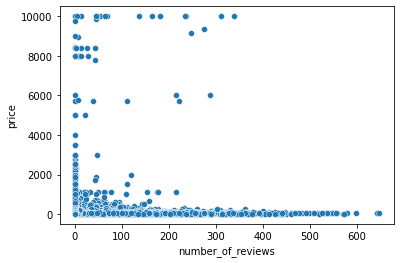

In [24]:
sns.scatterplot(x='number_of_reviews', y='price', data=accommodations)

Number of reviews is not correlated

## Statistical analysis

These analysis can help you to forge your presentation but you are **strongly encouraged** to follow your own findings.

### Hotel room statistics

The Airbnb team is really interested in the **Hotel rooms** so you will have to answer some questions about it. 

To do so, we are considering a binary segmentation: **Hotel rooms vs the rest**.

**❓ Using a statistical test, can you tell than Hotel rooms are statistically more expensive than the other rooms?**

Store the $p\text{-}value$ of your test inside a `p_value` variable.

In [25]:
# YOUR CODE HERE
accommodations.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

#### Create a column "Hotel_or_rest" to identify hotel rooms

In [26]:
accommodations["hotel_or_rest"] = accommodations["room_type"].apply(lambda row: "hotel" if row == "Hotel room" else "rest")

In [27]:
accommodations[accommodations["hotel_or_rest"]=="hotel"].head()

,id,price,neighbourhood,neighbourhood_group,bedrooms,beds,accommodates,amenities,minimum_nights,maximum_nights,...,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,property_type,review_scores_rating,number_of_reviews,yearly_availability,hotel_or_rest
1266,6083007,177.0,Cortes,Centro,2.0,5.0,6,"[""Smoke alarm"", ""Dishwasher"", ""Refrigerator"", ...",1,1125,...,NaN,NaN,40.41338,-3.69727,Hotel room,Room in serviced apartment,98.0,135,290.0,hotel
1414,6743322,46.0,Cortes,Centro,1.0,2.0,2,"[""Elevator"", ""Paid parking off premises"", ""Smo...",1,10,...,t,t,40.41421,-3.70192,Hotel room,Room in boutique hotel,96.0,21,365.0,hotel
2147,10275785,108.0,Argüelles,Moncloa - Aravaca,1.0,4.0,4,"[""TV with standard cable"", ""Kitchen"", ""Elevato...",1,1125,...,t,f,40.42234,-3.71549,Hotel room,Room in serviced apartment,85.0,4,350.0,hotel
2442,11808208,109.0,Justicia,Centro,2.0,3.0,4,"[""Dishwasher"", ""Bed linens"", ""Refrigerator"", ""...",1,1125,...,t,t,40.42302,-3.69742,Hotel room,Room in serviced apartment,94.0,39,148.0,hotel
2456,11883513,87.0,Castellana,Salamanca,1.0,1.0,4,"[""Kitchen"", ""Elevator"", ""Paid parking off prem...",1,1125,...,t,t,40.43343,-3.67959,Hotel room,Room in serviced apartment,90.0,57,234.0,hotel


In [28]:
model = smf.ols(formula='price ~ C(hotel_or_rest) -1', data=accommodations).fit()

In [29]:
p_value = model.pvalues
p_value

C(hotel_or_rest)[hotel]     1.614222e-20
C(hotel_or_rest)[rest]     2.036255e-261
dtype: float64

Hotel prices are on average 1.614222e-20 higher than the rest of property types

Check hotel mean price just by curiosity

In [30]:
hotel_prices = accommodations[accommodations["hotel_or_rest"]=="hotel"]["price"]

In [31]:
hotel_mean_price = hotel_prices.sum()/len(hotel_prices)
hotel_mean_price

370.63157894736844

Check rest mean price

In [32]:
rest_prices = accommodations[accommodations["hotel_or_rest"]=="rest"]["price"]

In [33]:
rest_mean_price = rest_prices.sum()/len(rest_prices)
rest_mean_price

130.16970730321114

### Price room analysis

**❓ Plot the distribution of the prices?**

ℹ️ Use the accommodations with price lower than $200 for a better visualization

In [34]:
# YOUR CODE HERE
accommodations_under_200 = accommodations[accommodations["price"]<200]

In [35]:
accommodations.shape

(17747, 28)

In [36]:
accommodations_under_200.shape

(15985, 28)

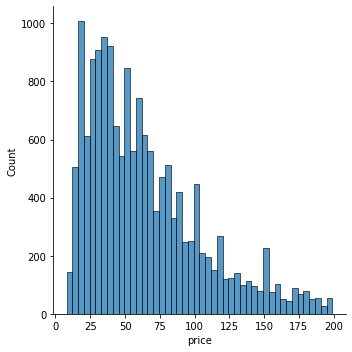

In [37]:
sns.displot(accommodations_under_200["price"])

**❓ What do think about that distribution?**

It follows a normal distribution but not centered reduced

**📝 What transformation would you use to the price to fit a linear model? Transform your target as you see fit.**

I would use a standard scaler to center and reduce the distribution (µ = 0 and σ = 1)


**❓ Can we explain the price for a customer with our features?**

Using the numerical and the categorical features of your choice, try to fit a not too complex model to explain the price of an accommodation.

Store the `summary` of the model inside a `model_summary` variable.

#### Create a model

In [38]:
accommodations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17747 entries, 0 to 17746
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      17747 non-null  int64  
 1   price                   17747 non-null  float64
 2   neighbourhood           17747 non-null  object 
 3   neighbourhood_group     17747 non-null  object 
 4   bedrooms                17747 non-null  float64
 5   beds                    17747 non-null  float64
 6   accommodates            17747 non-null  int64  
 7   amenities               17747 non-null  object 
 8   minimum_nights          17747 non-null  int64  
 9   maximum_nights          17747 non-null  int64  
 10  host_id                 17747 non-null  int64  
 11  host_since              17268 non-null  object 
 12  host_neighbourhood      11605 non-null  object 
 13  host_location           17229 non-null  object 
 14  host_response_time      10042 non-null

##### Check unique values of features to evaluate if I should keep them or not

In [39]:
accommodations["room_type"].unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

##### Select the features in a list

In [40]:
model_features = ["neighbourhood_group", "bedrooms", "room_type", "review_scores_rating", "number_of_reviews", "yearly_availability", "price"]

##### Create a new DataFrame named "data"

In [41]:
data = accommodations[model_features]
data.head()

,neighbourhood_group,bedrooms,room_type,review_scores_rating,number_of_reviews,yearly_availability,price
0,Chamartín,1.0,Private room,98.0,78,180.0,60.0
1,Latina,1.0,Private room,92.0,33,364.0,31.0
2,Arganzuela,3.0,Entire home/apt,NaN,0,366.0,50.0
3,Arganzuela,1.0,Private room,94.0,149,365.0,26.0
4,Arganzuela,3.0,Entire home/apt,80.0,3,365.0,85.0


##### Clean it

In [42]:
data.shape

(17747, 7)

##### Drop duplicates

In [43]:
data = data.drop_duplicates()

In [44]:
data.shape

(16874, 7)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16874 entries, 0 to 17746
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   neighbourhood_group   16874 non-null  object 
 1   bedrooms              16874 non-null  float64
 2   room_type             16874 non-null  object 
 3   review_scores_rating  12405 non-null  float64
 4   number_of_reviews     16874 non-null  int64  
 5   yearly_availability   12889 non-null  float64
 6   price                 16874 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.0+ MB


##### Impute numerical values

In [46]:
numerical_columns = [column_name for column_name in list(data.columns) if data.dtypes[column_name]!="object"]

In [47]:
imputer = SimpleImputer(strategy="mean")

for column_name in numerical_columns:
    imputer.fit(data[[column_name]])
    data[column_name] = imputer.transform(data[[column_name]])

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16874 entries, 0 to 17746
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   neighbourhood_group   16874 non-null  object 
 1   bedrooms              16874 non-null  float64
 2   room_type             16874 non-null  object 
 3   review_scores_rating  16874 non-null  float64
 4   number_of_reviews     16874 non-null  float64
 5   yearly_availability   16874 non-null  float64
 6   price                 16874 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.0+ MB


We don't need to impute categorical values

##### Check each unique values per column to see if there are some weird ones to handle

In [49]:
data.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

review_scores_rating and yearly_availability has both only one value which need a float type. We will change their type to int

In [50]:
data.review_scores_rating = data.review_scores_rating.astype(int)
data.yearly_availability = data.yearly_availability.astype(int)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16874 entries, 0 to 17746
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   neighbourhood_group   16874 non-null  object 
 1   bedrooms              16874 non-null  float64
 2   room_type             16874 non-null  object 
 3   review_scores_rating  16874 non-null  int64  
 4   number_of_reviews     16874 non-null  float64
 5   yearly_availability   16874 non-null  int64  
 6   price                 16874 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.0+ MB


##### Encode categorical columns

In [52]:
# categorical_columns = [column_name for column_name in list(data.columns) if data.dtypes[column_name]=="object"]
# categorical_columns

In [53]:
# encoded_columns = []
# for column_name in categorical_columns:
#     counter = 0
#     # Instanciate encoder
#     ohe = OneHotEncoder(sparse = False)
#     # Fit encoder
#     ohe.fit(data[[column_name]])
#     # Give the right name to the encoded column
#     categorical_column_encoded = ohe.transform(data[[column_name]])
#     # Check how many unique values we will encode
#     unique_values_per_column = len(data[column_name].value_counts())
#     for value in range(unique_values_per_column):
#         # Column new value
#         new_column_name = ohe.categories_[0][counter]
#         # Create the new column
#         data[new_column_name] = categorical_column_encoded.T[counter]
#         # Add the new column name to the list for check after process
#         encoded_columns.append(new_column_name)
#         counter += 1

In [54]:
# encoded_columns

##### Drop categorical columns

In [55]:
# data.shape

In [56]:
# data = data.drop(columns=categorical_columns)

In [57]:
# data.shape

Because we have imputed numerical values, we should see once again if there are some duplicates

In [58]:
# data = data.drop_duplicates()

In [59]:
# data.shape

##### Ok, the dataset is clean, now we can start to build the model

##### Split the data set

In [60]:
# X = data.drop(columns=['price'])
# y = data['price']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [61]:
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

##### Instanciate, fit and score the model

In [62]:
# # Instanciate the model
# model = LinearRegression()
# # Fit it
# model.fit(X_train, y_train)

In [63]:
# model.summary()

Ok, there is no summary for LinearRegression models so we will build it in an other way

In [64]:
model_features

['neighbourhood_group',
 'bedrooms',
 'room_type',
 'review_scores_rating',
 'number_of_reviews',
 'yearly_availability',
 'price']

In [65]:
model = smf.ols(formula='price ~ C(neighbourhood_group) + bedrooms + C(room_type) + review_scores_rating + number_of_reviews + yearly_availability -1', data=data).fit()

In [66]:
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     18.97
Date:                Fri, 01 Oct 2021   Prob (F-statistic):           1.49e-89
Time:                        17:20:33   Log-Likelihood:            -1.2867e+05
No. Observations:               16874   AIC:                         2.574e+05
Df Residuals:                   16846   BIC:                         2.576e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
C(neighbourhood_group)[Arganzuela]               55.6258     45.709      1.217      0.224     -33.970     145.221
C(neighbourhood_group)[Barajas]                  46.8195     59.006      0.793      0.428     -68.838     162.477
C(neighbourhood_group)[Carabanchel]              19.2011     47.614      0.403      0.687     -74.127     112.529
C(neighbourhood_group)[Centro]                   29.4688     42.993      0.685      0.493     -54.802     113.739
C(neighbourhood_group)[Chamartín]                21.0824     48.383      0.436      0.663     -73.754     115.919
C(neighbourhood_group)[Chamberí]                 25.6340     45.600      0.562      0.574     -63.747     115.015
C(neighbourhood_group)[Ciudad Lineal]            37.2189     48.438      0.768      0.442     -57.725     132.163
C(neighbourhood_group)[Fuencarral - El Pardo]    34.2736     53.115      0.645      0.519     -69.837     138.385
C(neighbourhood_group)[Hortaleza]                50.4807     51.366      0.983      0.326     -50.202     151.164
C(neighbourhood_group)[Latina]                   78.4447     48.444      1.619      0.105     -16.510     173.399
C(neighbourhood_group)[Moncloa - Aravaca]        27.0826     48.755      0.555      0.579     -68.482     122.648
C(neighbourhood_group)[Moratalaz]                11.2434     65.396      0.172      0.863    -116.940     139.427
C(neighbourhood_group)[Puente de Vallecas]        5.9791     48.203      0.124      0.901     -88.504     100.463
C(neighbourhood_group)[Retiro]                   23.0239     47.762      0.482      0.630     -70.594     116.642
C(neighbourhood_group)[Salamanca]                54.1087     45.079      1.200      0.230     -34.252     142.469
C(neighbourhood_group)[San Blas - Canillejas]   253.6461     49.607      5.113      0.000     156.412     350.880
C(neighbourhood_group)[Tetuán]                   38.2757     46.816      0.818      0.414     -53.488     130.039
C(neighbourhood_group)[Usera]                    24.8294     53.827      0.461      0.645     -80.676     130.335
C(neighbourhood_group)[Vicálvaro]                92.0901     75.042      1.227      0.220     -54.999     239.180
C(neighbourhood_group)[Villa de Vallecas]        18.7670     68.754      0.273      0.785    -115.998     153.532
C(neighbourhood_group)[Villaverde]              134.8903     58.045      2.324      0.020      21.116     248.665
C(room_type)[T.Hotel room]                      218.3918     41.675      5.240      0.000     136.704     300.080
C(room_type)[T.Private room]                    -50.2734      8.846     -5.683      0.000     -67.612     -32.935
C(room_type)[T.Shared room]                     -28.3049     30.116     -0.940      0.347     -87.336      30.726
bedro

In [67]:
model_params = model.params
model_params.sort_values(ascending=False)

C(neighbourhood_group)[San Blas - Canillejas]    253.646139
C(room_type)[T.Hotel room]                       218.391820
C(neighbourhood_group)[Villaverde]               134.890313
C(neighbourhood_group)[Vicálvaro]                 92.090118
C(neighbourhood_group)[Latina]                    78.444734
bedrooms                                          75.464975
C(neighbourhood_group)[Arganzuela]                55.625848
C(neighbourhood_group)[Salamanca]                 54.108716
C(neighbourhood_group)[Hortaleza]                 50.480708
C(neighbourhood_group)[Barajas]                   46.819529
C(neighbourhood_group)[Tetuán]                    38.275724
C(neighbourhood_group)[Ciudad Lineal]             37.218870
C(neighbourhood_group)[Fuencarral - El Pardo]     34.273590
C(neighbourhood_group)[Centro]                    29.468759
C(neighbourhood_group)[Moncloa - Aravaca]         27.082601
C(neighbourhood_group)[Chamberí]                  25.634010
C(neighbourhood_group)[Usera]           

**❓ What features explain the best the price of an accommodation in Madrid?**
- Which ones are the most statistically significant?
- Which numerical feature is the most sensitive to the price?

In this case, the most statistically significant feature is "neighbourhood_group"

**❓ Explain with your own words the impact of an increase of one unity of the feature of your choice on the price of an accommodation.**

For each accomodation placed in "San Blas - Canillejas", the price increase on average by 254 Euros.

**❓ Are you satisfied with your model? Why?**

- No I am not, the R-squared is at only 0.030. 
- When we know that it possible values are between 0 and 1 and that for this metric, the higher is the better, we can consider that a model with a R-squared at 0.030 is very bad.

**❓Are you confident in the p-values of your model?**

In [68]:
# YOUR CODE HERE
model_p_values = model.pvalues
model_p_values.sort_values(ascending=False)

C(neighbourhood_group)[Puente de Vallecas]       9.012852e-01
C(neighbourhood_group)[Moratalaz]                8.634970e-01
C(neighbourhood_group)[Villa de Vallecas]        7.848890e-01
C(neighbourhood_group)[Carabanchel]              6.867578e-01
C(neighbourhood_group)[Chamartín]                6.630323e-01
C(neighbourhood_group)[Usera]                    6.446001e-01
C(neighbourhood_group)[Retiro]                   6.297720e-01
C(neighbourhood_group)[Moncloa - Aravaca]        5.785718e-01
C(neighbourhood_group)[Chamberí]                 5.740234e-01
review_scores_rating                             5.489530e-01
C(neighbourhood_group)[Fuencarral - El Pardo]    5.187604e-01
C(neighbourhood_group)[Centro]                   4.930786e-01
number_of_reviews                                4.888062e-01
C(neighbourhood_group)[Ciudad Lineal]            4.422738e-01
C(neighbourhood_group)[Barajas]                  4.275142e-01
C(neighbourhood_group)[Tetuán]                   4.136058e-01
C(room_t

I am not confident in the p-values of the model because it is not relevant with a r-squared at 0.030.

### 💾 Save your results

Run the cell below to save your results.

In [69]:
from nbresult import ChallengeResult

result = ChallengeResult('analysis', p_value=p_value, model_summary=str(model_summary))
result.write()

## CEO question

> **How can we increase the average rating of the accommodations in Madrid to 95% while keeping the revenue as high as possible?**

[BONUS] In addition could you give some advices / quick wins to Airbnb Hosts Team in order to help hosts increasing their accommodation price while onboarding on the platform.

⚠️ We suppose for this study that: 
- An accommodation is booked **60%** of the available time
- Airbnb takes a **5% fee** on the revenue per accommodation
- The actions you will recommend have a _negligible impact_ on the actual charges of Airbnb

- If an accommodation is booked 60% of the available time then we can compute a max income column

In [70]:
accommodations["max_income"] = accommodations["yearly_availability"] * accommodations["price"] * 0.6

- If Airbnb tales 5% fee on the revenue per accommodation we can compute its max income too

In [71]:
accommodations["airbnb_max_income"] = accommodations["max_income"] * 0.05

In [72]:
accommodations.head()

,id,price,neighbourhood,neighbourhood_group,bedrooms,beds,accommodates,amenities,minimum_nights,maximum_nights,...,latitude,longitude,room_type,property_type,review_scores_rating,number_of_reviews,yearly_availability,hotel_or_rest,max_income,airbnb_max_income
0,6369,60.0,Hispanoamérica,Chamartín,1.0,1.0,2,"[""Kitchen"", ""Elevator"", ""Extra pillows and bla...",1,1125,...,40.45724,-3.67688,Private room,Private room in apartment,98.0,78,180.0,rest,6480.0,324.00
1,21853,31.0,Cármenes,Latina,1.0,1.0,1,"[""Bed linens"", ""Refrigerator"", ""Dishes and sil...",4,40,...,40.40381,-3.74130,Private room,Private room in apartment,92.0,33,364.0,rest,6770.4,338.52
2,23001,50.0,Legazpi,Arganzuela,3.0,5.0,6,"[""Pool"", ""Dishwasher"", ""Bed linens"", ""Refriger...",15,730,...,40.38840,-3.69511,Entire home/apt,Entire apartment,NaN,0,366.0,rest,10980.0,549.00
3,26825,26.0,Legazpi,Arganzuela,1.0,1.0,1,"[""Elevator"", ""Patio or balcony"", ""Bed linens"",...",2,1125,...,40.38975,-3.69018,Private room,Private room in house,94.0,149,365.0,rest,5694.0,284.70
4,28200,85.0,Legazpi,Arganzuela,3.0,4.0,6,"[""TV with standard cable"", ""Kitchen"", ""Elevato...",1,365,...,40.38860,-3.69492,Entire home/apt,Entire apartment,80.0,3,365.0,rest,18615.0,930.75


In [73]:
accommodations.shape

(17747, 30)

### What is the actual average rating ?

- Only keep the accommodations with a rating value and a yearly availability

In [74]:
airbnb = accommodations.drop(accommodations[accommodations["review_scores_rating"].isnull() == 1].index)

In [75]:
airbnb = airbnb.drop(airbnb[airbnb["yearly_availability"].isnull() == 1].index)

In [76]:
airbnb.shape

(9508, 30)

In [77]:
mean_rating_score = airbnb.review_scores_rating.mean()
mean_rating_score

92.5539545645772

### How to increase it ?

#### Airbnb incomes

In [78]:
actual_airbnb_incomes = round(airbnb.max_income.sum(),2)
actual_airbnb_incomes

118951977.6

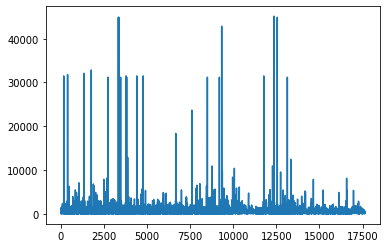

In [79]:
plt.plot(airbnb.airbnb_max_income)

### Let's analyze Airbnb insights about hotels

In [80]:
airbnb.room_type.value_counts()

Entire home/apt    6063
Private room       3209
Shared room         155
Hotel room           81
Name: room_type, dtype: int64

In [81]:
airbnb_hotels = airbnb[airbnb["room_type"]=="Hotel room"]
airbnb_hotels["review_scores_rating"].mean()

91.8641975308642

In [82]:
airbnb_hotels_income_percentage = round((airbnb_hotels["airbnb_max_income"].sum()/actual_airbnb_incomes)*100,2)
airbnb_hotels_income_percentage

0.13

In [83]:
print(f"Aribnb business with hotels represent {airbnb_hotels_income_percentage}% of its incomes")

Aribnb business with hotels represent 0.13% of its incomes


### What about shared rooms ?

In [84]:
airbnb_shared_rooms = airbnb[airbnb["room_type"]=="Shared room"]
airbnb_shared_rooms["review_scores_rating"].mean()

89.35483870967742

In [85]:
airbnb_shared_rooms_income_percentage = round((airbnb_shared_rooms["airbnb_max_income"].sum()/actual_airbnb_incomes)*100,2)
airbnb_shared_rooms_income_percentage

0.04

In [86]:
print(f"Aribnb business with shared rooms represent {airbnb_shared_rooms_income_percentage}% of its incomes")

Aribnb business with shared rooms represent 0.04% of its incomes


### What would be airbnb performance without these activities ?

In [87]:
income_per_activity = airbnb.pivot_table(values='airbnb_max_income', index=['room_type'], aggfunc='sum')
income_per_activity

,airbnb_max_income
room_type,
Entire home/apt,4868217.63
Hotel room,156896.49
Private room,880685.19
Shared room,41799.57


# How can we increase the average rating of the accommodations in Madrid ?

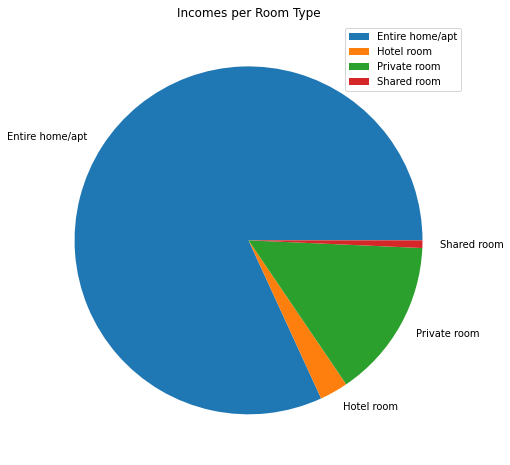

In [88]:
income_per_activity.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("Incomes per Room Type")
plt.ylabel("")
plt.show()

In [89]:
rating_score_peractivity = airbnb.pivot_table(values='review_scores_rating', index=['room_type'], margins=True, aggfunc='mean')
rating_score_peractivity

,review_scores_rating
room_type,
Entire home/apt,92.518390
Hotel room,91.864198
Private room,92.793082
Shared room,89.354839
All,92.553955


In [90]:
airbnb_without_bad_activities = airbnb.loc[airbnb['room_type'].isin(["Entire home/apt", "Private room"])]
airbnb_without_bad_activities.shape

(9272, 30)

In [91]:
rating_score_good_peractivity = airbnb_without_bad_activities.pivot_table(values='review_scores_rating', index=['room_type'], margins=True, aggfunc='mean')
rating_score_good_peractivity

,review_scores_rating
room_type,
Entire home/apt,92.518390
Private room,92.793082
All,92.613460


In [92]:
diff = 92.613460-92.553955
diff

0.05950500000000147

In [93]:
after_airbnb_incomes = round(airbnb_without_bad_activities.max_income.sum(),2)
after_airbnb_incomes

114978056.4

In [94]:
income_diff = ((actual_airbnb_incomes - after_airbnb_incomes)/actual_airbnb_incomes)*100
income_diff

3.3407777492889603

In [95]:
print(f"If we continue to work without 'Hotel room' and 'Shared room' we would increase our average rating score by 0.06 points and only loose 3 points of incomes")

If we continue to work without 'Hotel room' and 'Shared room' we would increase our average rating score by 0.06 points and only loose 3 points of incomes


### NLP

#### First clean amenities column to analyze what's inside

In [96]:
# def clean (text):
    
#     for punctuation in string.punctuation:
#         text = text.replace(punctuation, ' ') # Remove Punctuation
        
#     lowercased = text.lower() # Lower Case
    
#     unaccented_string = unidecode.unidecode(lowercased) # remove accents
    
#     tokenized = word_tokenize(unaccented_string) # Tokenize
    
#     words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    
#     stop_words = set(stopwords.words('english')) # Make stopword list
    
#     without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    
#     return " ".join(without_stopwords)

In [97]:
# airbnb['clean_amenities'] = airbnb['amenities'].apply(clean)

# airbnb.head()

#### Filter on bad reviews - Rating score under 65

In [98]:
# airbnb_bad_reviews = airbnb[airbnb["review_scores_rating"]<65]
# airbnb_bad_reviews.shape

In [99]:
# # Tuned TFidfvectorizer
# vec = TfidfVectorizer(ngram_range = (1,1), min_df=0.01, max_df = 0.05).fit(airbnb_bad_reviews["clean_amenities"])

# vectors = vec.transform(airbnb_bad_reviews["clean_amenities"]) # Transform text to vectors

# sum_tfidf = vectors.sum(axis=0) # Sum of tfidf weighting by word

# tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in vec.vocabulary_.items()]  # Get the word and associated weight

# sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  # Sort

# sorted_tfidf_list[:10]

In [100]:
# # Filter out accommodations with bad amenities

# airbnb_bad_amenities = airbnb[airbnb['clean_amenities'].str.contains("checkout")]

# airbnb_bad_amenities["review_scores_rating"].mean()

In [101]:
# airbnb_bad_amenities.shape

In [102]:
# airbnb_bad_amenities_bad_reviews = airbnb_bad_amenities[airbnb_bad_amenities["review_scores_rating"]<75]
# airbnb_bad_amenities_bad_reviews.shape

In [103]:
# for amenitie in airbnb_bad_amenities_bad_reviews["amenities"]:
#     print(amenitie)

Nothing seems relevant when we analyze amenities

### Neighbourhoods performance

#### Groupby accommodations neighbourhood and aggregate mean, min, max review scores

In [104]:
# neighbourhood_performance = airbnb.groupby('neighbourhood').agg({'review_scores_rating': ['count','mean', 'min', 'max']}).sort_values([('review_scores_rating','mean')],ascending=False)

# neighbourhood_performance.head()

#### Check only the bad ratings - with a mean score rating under 85

In [105]:
# neighbourhood_bad_performance = neighbourhood_performance[neighbourhood_performance[('review_scores_rating','mean')] <= 85]

# neighbourhood_bad_performance.tail()

- Cuatro Vientos seems a good sample to analyze

In [106]:
# cuatro_vientos = airbnb[airbnb['neighbourhood'] == 'Cuatro Vientos']

# cuatro_vientos

#### Is there some amenities that negatively impact the reviews score ?

In [107]:
# los_rosales_bad_reviews = los_rosales[los_rosales['review_scores_rating']<80]

# los_rosales_bad_reviews.head()

#### Or positively ?

## Presentation

Based on the analysis of the `accommodations` dataset, prepare a slides deck to present your conclusions to the CEO of Airbnb Spain. The presentation must contain **5 slides maximum** (including the title slide). 

💡 The CEO is in fond of illustrations, figures and statistics.


ℹ️ You may follow the [pyramid principle](https://gettingbettereveryday.org/2018/10/05/what-you-could-learn-from-barbra-mintos-the-pyramid-principle-2009-172-pages/) with an inductive approach, actions first!


⚠️ Save your presentation at the root of the repository.

🚀 You turn!

# Let's continue

## This is not about neighbourhoods

In [108]:
airbnb.head()

,id,price,neighbourhood,neighbourhood_group,bedrooms,beds,accommodates,amenities,minimum_nights,maximum_nights,...,latitude,longitude,room_type,property_type,review_scores_rating,number_of_reviews,yearly_availability,hotel_or_rest,max_income,airbnb_max_income
0,6369,60.0,Hispanoamérica,Chamartín,1.0,1.0,2,"[""Kitchen"", ""Elevator"", ""Extra pillows and bla...",1,1125,...,40.45724,-3.67688,Private room,Private room in apartment,98.0,78,180.0,rest,6480.0,324.00
1,21853,31.0,Cármenes,Latina,1.0,1.0,1,"[""Bed linens"", ""Refrigerator"", ""Dishes and sil...",4,40,...,40.40381,-3.74130,Private room,Private room in apartment,92.0,33,364.0,rest,6770.4,338.52
3,26825,26.0,Legazpi,Arganzuela,1.0,1.0,1,"[""Elevator"", ""Patio or balcony"", ""Bed linens"",...",2,1125,...,40.38975,-3.69018,Private room,Private room in house,94.0,149,365.0,rest,5694.0,284.70
4,28200,85.0,Legazpi,Arganzuela,3.0,4.0,6,"[""TV with standard cable"", ""Kitchen"", ""Elevato...",1,365,...,40.38860,-3.69492,Entire home/apt,Entire apartment,80.0,3,365.0,rest,18615.0,930.75
5,30320,65.0,Sol,Centro,1.0,2.0,2,"[""TV with standard cable"", ""Heating"", ""Air con...",5,180,...,40.41476,-3.70418,Entire home/apt,Entire apartment,93.0,170,351.0,rest,13689.0,684.45


In [109]:
review_per_neighbourhood = airbnb.pivot_table(values='review_scores_rating', index=['neighbourhood'], aggfunc='mean').sort_values(by='review_scores_rating')
review_per_neighbourhood

,review_scores_rating
neighbourhood,
El Plantío,83.000000
Cuatro Vientos,83.500000
Apostol Santiago,84.333333
Los Rosales,85.318182
Pavones,86.500000
...,...
Estrella,97.666667
Media Legua,97.666667
Amposta,98.000000


In [110]:
bad_neighbourhoods_pivot_table = review_per_neighbourhood[review_per_neighbourhood["review_scores_rating"]<85]
list_bad_neighbourhoods = list(bad_neighbourhoods_pivot_table.index)
list_bad_neighbourhoods

['El Plantío', 'Cuatro Vientos', 'Apostol Santiago']

In [111]:
bad_neighbourhoods = airbnb[airbnb["neighbourhood"].isin(list_bad_neighbourhoods)]
bad_neighbourhoods.shape

(25, 30)

In [112]:
bad_neighbourhoods["review_scores_rating"]

931       97.0
1442      94.0
1668     100.0
2382      94.0
3506      98.0
4034      80.0
4347      96.0
5283      96.0
5598      85.0
5723      20.0
7317      94.0
8367      77.0
8408      91.0
8626      95.0
8750      40.0
9860      98.0
10365    100.0
11755     87.0
12352    100.0
13147    100.0
13616     90.0
13853    100.0
14221     60.0
16663     20.0
16786     80.0
Name: review_scores_rating, dtype: float64

## Let's find what are the similarities about bad reviews

In [113]:
airbnb["review_scores_rating"].value_counts(ascending=False).sort_index(ascending=False)

100.0    1964
99.0      442
98.0      690
97.0      699
96.0      701
95.0      667
94.0      513
93.0      594
92.0      377
91.0      333
90.0      505
89.0      243
88.0      196
87.0      195
86.0      102
85.0      144
84.0      124
83.0      102
82.0       65
81.0       27
80.0      395
79.0        6
78.0       11
77.0       13
76.0       14
75.0       21
74.0        4
73.0       36
72.0        5
71.0        3
70.0       38
69.0        4
68.0        5
67.0       24
65.0        4
64.0        1
63.0        7
60.0      112
57.0        3
56.0        1
55.0        3
53.0        5
50.0       12
48.0        1
47.0        4
40.0       39
30.0        3
28.0        1
20.0       50
Name: review_scores_rating, dtype: int64

In [114]:
review_at_20 = airbnb[airbnb["review_scores_rating"]==20]
print(review_at_20.shape)
print(review_at_20["review_scores_rating"].value_counts())

(50, 30)
20.0    50
Name: review_scores_rating, dtype: int64


In [115]:
list(airbnb.columns)

['id',
 'price',
 'neighbourhood',
 'neighbourhood_group',
 'bedrooms',
 'beds',
 'accommodates',
 'amenities',
 'minimum_nights',
 'maximum_nights',
 'host_id',
 'host_since',
 'host_neighbourhood',
 'host_location',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'latitude',
 'longitude',
 'room_type',
 'property_type',
 'review_scores_rating',
 'number_of_reviews',
 'yearly_availability',
 'hotel_or_rest',
 'max_income',
 'airbnb_max_income']

In [116]:
review_at_20_details = review_at_20.pivot_table(values='review_scores_rating', index=['neighbourhood_group'], aggfunc='count').sort_values('review_scores_rating', ascending=False)
review_at_20_details

,review_scores_rating
neighbourhood_group,
Centro,19
Salamanca,6
Carabanchel,5
Chamberí,3
Chamartín,2
Hortaleza,2
Latina,2
Puente de Vallecas,2
Retiro,2


In [117]:
print(review_at_20.shape)
review_at_20["neighbourhood_group"].value_counts()

(50, 30)


Centro                   19
Salamanca                 6
Carabanchel               5
Chamberí                  3
Hortaleza                 2
Puente de Vallecas        2
Retiro                    2
Villa de Vallecas         2
Latina                    2
Chamartín                 2
Arganzuela                1
Moncloa - Aravaca         1
San Blas - Canillejas     1
Villaverde                1
Usera                     1
Name: neighbourhood_group, dtype: int64

In [118]:
review_at_20 = review_at_20[review_at_20["neighbourhood_group"]=="Centro"]
review_at_20["neighbourhood_group"].value_counts()

Centro    19
Name: neighbourhood_group, dtype: int64

In [119]:
review_at_20[['host_since','host_neighbourhood','host_location','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_has_profile_pic','host_identity_verified']]

,host_since,host_neighbourhood,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified
5412,2016-10-19,NaN,"Madrid, Community of Madrid, Spain",a few days or more,29%,100%,f,t,t
5824,2017-10-26,Sol,"Madrid, Community of Madrid, Spain",a few days or more,0%,44%,f,t,f
6321,2018-01-25,NaN,ES,NaN,NaN,NaN,f,t,f
9598,2017-07-11,Malasaña,"Madrid, Community of Madrid, Spain",a few days or more,30%,83%,f,t,t
12224,2014-11-14,Embajadores,"Madrid, Community of Madrid, Spain",within a day,70%,50%,f,t,t
12477,2013-01-23,NaN,"Madrid, Community of Madrid, Spain",NaN,NaN,100%,f,t,f
12533,2019-09-17,La Latina,"Madrid, Community of Madrid, Spain",NaN,NaN,NaN,f,t,f
13345,2019-11-07,NaN,"Madrid, Comunidad de Madrid, Spain",within an hour,80%,82%,f,t,t
14037,2020-01-17,Sants-Montjuïc,ES,NaN,NaN,NaN,f,t,f
14551,2020-02-17,NaN,"Madrid, Community of Madrid, Spain",NaN,NaN,NaN,f,t,t


In [120]:
review_at_20_details = review_at_20.pivot_table(values='review_scores_rating', index=[
 'amenities',
 'minimum_nights',
 'maximum_nights',
 'host_id',
 'host_since',
 'host_neighbourhood',
 'host_location',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'latitude',
 'longitude',
 'room_type',
 'property_type',
 'number_of_reviews',
 'yearly_availability',
 'hotel_or_rest',
 'max_income',
 'airbnb_max_income'], aggfunc='sum').sort_values('review_scores_rating', ascending=False)

review_at_20_details.shape

(4, 1)

In [121]:
review_at_20_details

,,,,,,,,,,,,,,,,,,,,,,review_scores_rating
amenities,minimum_nights,maximum_nights,host_id,host_since,host_neighbourhood,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,property_type,number_of_reviews,yearly_availability,hotel_or_rest,max_income,airbnb_max_income,
"[""Kitchen"", ""Fire extinguisher"", ""Hangers"", ""Iron"", ""Wifi"", ""Heating"", ""Hot water"", ""Security cameras on property"", ""Host greets you"", ""Long term stays allowed"", ""First aid kit"", ""Hair dryer"", ""Essentials""]",2,1118,139789014,2017-07-11,Malasaña,"Madrid, Community of Madrid, Spain",a few days or more,30%,83%,f,t,t,40.42500,-3.70749,Private room,Private room in house,1,365.0,rest,7665.0,383.25,20.0
"[""Kitchen"", ""Patio or balcony"", ""Iron"", ""Refrigerator"", ""Stove"", ""Wifi"", ""Cooking basics"", ""Hot water"", ""Dishes and silverware"", ""Long term stays allowed"", ""TV"", ""Hair dryer"", ""Dedicated workspace"", ""Essentials""]",1,30,22089497,2014-10-03,La Latina,"Madrid, Community of Madrid, Spain",within an hour,97%,75%,f,t,t,40.40970,-3.70976,Entire home/apt,Entire apartment,1,90.0,rest,1998.0,99.90,20.0
"[""Smoke alarm"", ""Dishwasher"", ""Bed linens"", ""Refrigerator"", ""Host greets you"", ""Dishes and silverware"", ""TV"", ""Carbon monoxide alarm"", ""Air conditioning"", ""Essentials"", ""Coffee maker"", ""Extra pillows and blankets"", ""Fire extinguisher"", ""Hangers"", ""Cooking basics"", ""Hot water"", ""Pocket wifi"", ""Hair dryer"", ""Dedicated workspace"", ""Stove"", ""Iron"", ""Long term stays allowed"", ""First aid kit"", ""Washer"", ""Kitchen"", ""Paid parking off premises"", ""Patio or balcony"", ""Oven"", ""Shampoo"", ""Microwave"", ""Wifi"", ""Heating""]",3,1125,23734195,2014-11-14,Embajadores,"Madrid, Community of Madrid, Spain",within a day,70%,50%,f,t,t,40.41148,-3.70067,Entire home/apt,Entire apartment,1,365.0,rest,26280.0,1314.00,20.0
"[""Smoke alarm"", ""TV"", ""Dryer"", ""Carbon monoxide alarm"", ""Air conditioning"", ""Essentials"", ""Building staff"", ""Fire extinguisher"", ""Hot water"", ""Hair dryer"", ""Dedicated workspace"", ""Elevator"", ""Luggage dropoff allowed"", ""Security cameras on property"", ""High chair"", ""Long term stays allowed"", ""First aid kit"", ""Washer"", ""Kitchen"", ""Shampoo"", ""Wifi"", ""Heating"", ""Children\u2019s books and toys""]",1,1125,156279074,2017-10-26,Sol,"Madrid, Community of Madrid, Spain",a few days or more,0%,44%,f,t,f,40.41653,-3.70173,Shared room,Shared room in bed and breakfast,1,365.0,rest,6789.0,339.45,20.0


## Let's go on host identity verified

In [122]:
host_id_df = airbnb.pivot_table(values='review_scores_rating', index=['host_identity_verified'], aggfunc='mean')
host_id_df

,review_scores_rating
host_identity_verified,
f,92.125397
t,92.637343


## Mapping Neighbourhoods groups

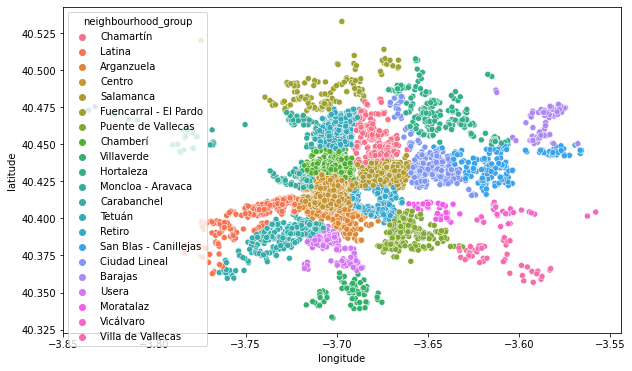

In [126]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=airbnb["longitude"],y=airbnb["latitude"],hue=airbnb["neighbourhood_group"])
plt.ioff()

In [129]:
airbnb["good_bad_ratings"] = airbnb["review_scores_rating"].apply(lambda x : "good" if x>65 else "bad")

In [133]:
airbnb["good_bad_ratings"].value_counts()

good    9262
bad      246
Name: good_bad_ratings, dtype: int64

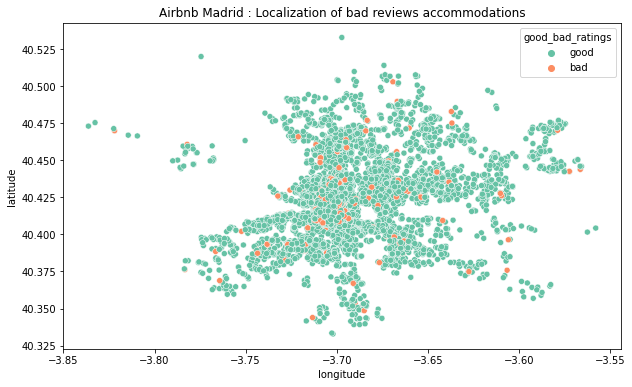

In [146]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=airbnb["longitude"],y=airbnb["latitude"],hue=airbnb["good_bad_ratings"], palette="Set2")
plt.title("Airbnb Madrid : Localization of bad reviews accommodations")
plt.ioff()

## Mapper la récurrence de mots

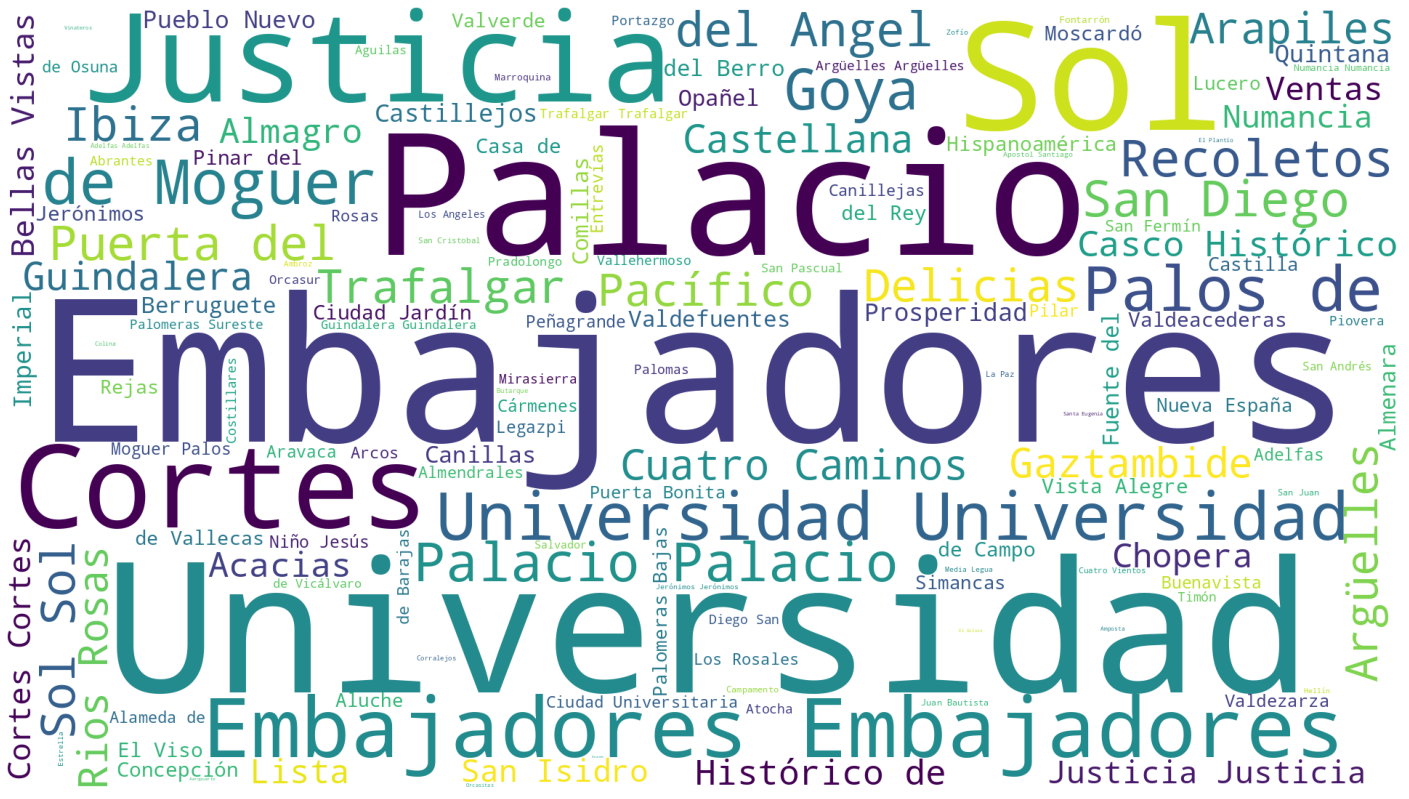

In [135]:
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='white', width=1920, height=1080).generate(" ".join(airbnb["neighbourhood"]))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('neighbourhood.png')
plt.show()

In [137]:
airbnb_bad_reviews = airbnb[airbnb["review_scores_rating"]<65]

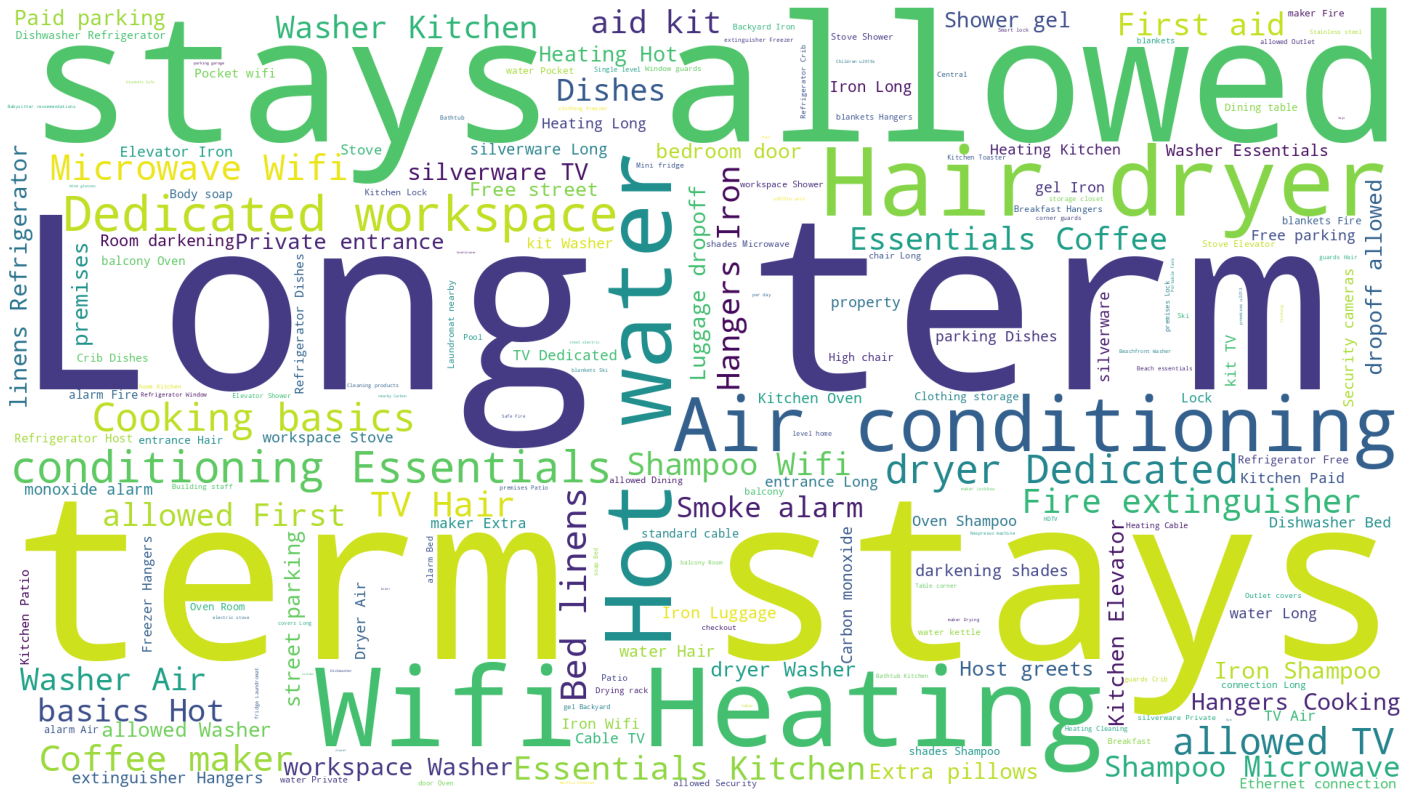

In [138]:
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='white', width=1920, height=1080).generate(" ".join(airbnb_bad_reviews["amenities"]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [142]:
airbnb_good_reviews = airbnb[airbnb["review_scores_rating"]>=65]

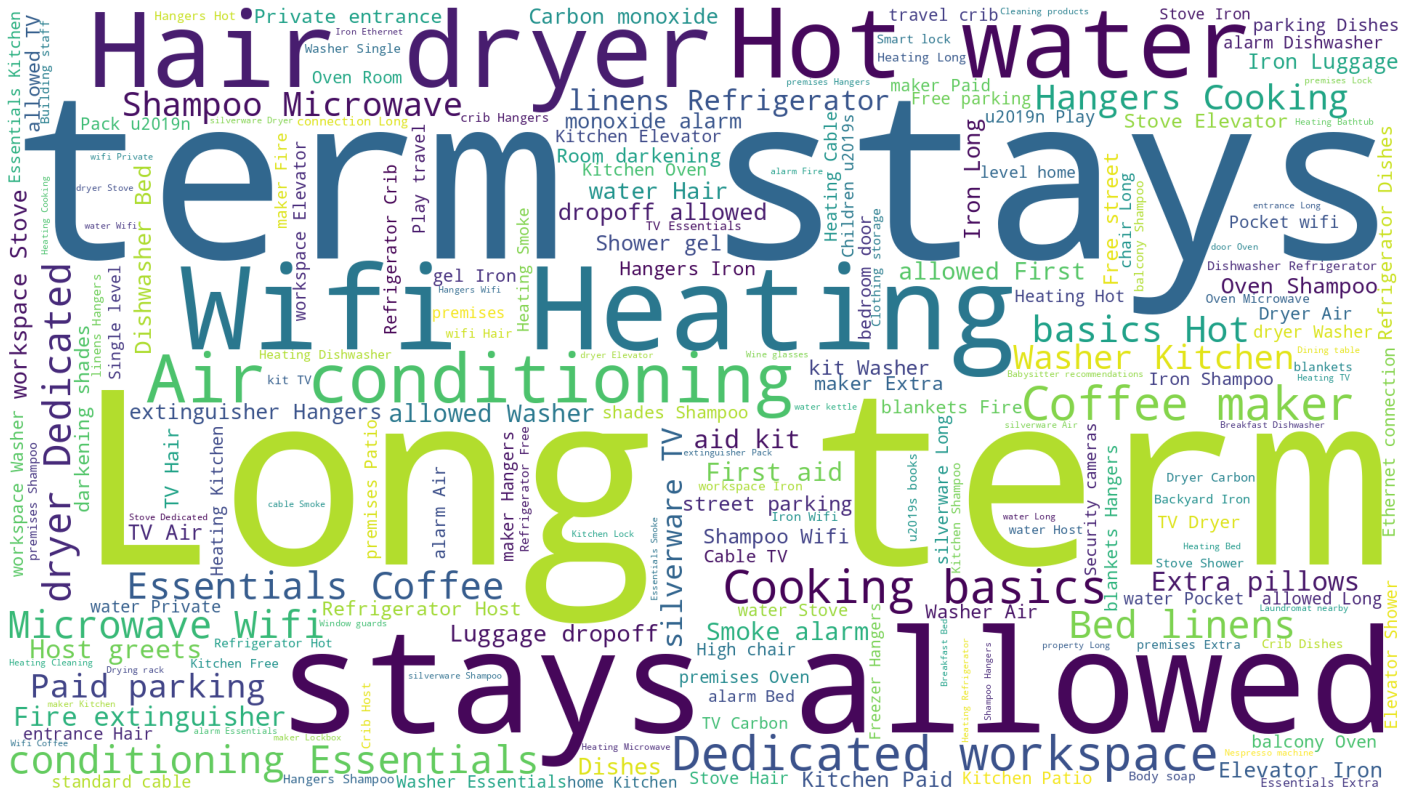

In [143]:
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(background_color='white', width=1920, height=1080).generate(" ".join(airbnb_good_reviews["amenities"]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# So... not localization, not amenities, not verified host ids, not room type,... What's remaining then ?

In [145]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 17652
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9508 non-null   int64  
 1   price                   9508 non-null   float64
 2   neighbourhood           9508 non-null   object 
 3   neighbourhood_group     9508 non-null   object 
 4   bedrooms                9508 non-null   float64
 5   beds                    9508 non-null   float64
 6   accommodates            9508 non-null   int64  
 7   amenities               9508 non-null   object 
 8   minimum_nights          9508 non-null   int64  
 9   maximum_nights          9508 non-null   int64  
 10  host_id                 9508 non-null   int64  
 11  host_since              9222 non-null   object 
 12  host_neighbourhood      6751 non-null   object 
 13  host_location           9212 non-null   object 
 14  host_response_time      7121 non-null  